# Install and Import Required Libraries

In [1]:
!pip install librosa soundfile

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, GlobalAveragePooling1D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch


import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

2025-06-19 09:50:23.544156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750326623.822076      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750326623.895150      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries imported successfully!


# Dataset Configuration and Emotion Mapping

In [2]:
DATA_PATH = "/kaggle/input/emotion-dataset/Emotion_Dataset"

# RAVDESS emotion mapping
emotions = {
    '01': 'neutral',
    '02': 'calm', 
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

print("Emotion mapping:")
for code, emotion in emotions.items():
    print(f"{code}: {emotion}")


Emotion mapping:
01: neutral
02: calm
03: happy
04: sad
05: angry
06: fearful
07: disgust
08: surprised


# Explore Dataset Structure

In [3]:
print("Dataset structure:")
for root, dirs, files in os.walk(DATA_PATH):
    level = root.replace(DATA_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files only
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files)-5} more files")


Dataset structure:
Emotion_Dataset/
  Speech/
    Actor_02/
      03-01-08-01-01-01-02.wav
      03-01-01-01-01-01-02.wav
      03-01-07-02-01-02-02.wav
      03-01-07-01-01-02-02.wav
      03-01-01-01-02-01-02.wav
      ... and 55 more files
    Actor_17/
      03-01-02-01-02-02-17.wav
      03-01-05-02-01-02-17.wav
      03-01-03-01-01-02-17.wav
      03-01-02-02-01-01-17.wav
      03-01-07-01-02-01-17.wav
      ... and 55 more files
    Actor_05/
      03-01-08-01-02-02-05.wav
      03-01-08-02-01-01-05.wav
      03-01-07-02-02-01-05.wav
      03-01-06-02-01-02-05.wav
      03-01-02-02-02-01-05.wav
      ... and 55 more files
    Actor_16/
      03-01-03-02-02-01-16.wav
      03-01-07-02-01-02-16.wav
      03-01-04-02-01-02-16.wav
      03-01-05-02-01-01-16.wav
      03-01-05-02-01-02-16.wav
      ... and 55 more files
    Actor_21/
      03-01-02-01-01-01-21.wav
      03-01-07-02-01-02-21.wav
      03-01-01-01-01-01-21.wav
      03-01-06-02-02-01-21.wav
      03-01-08-01-01-01-21.w

#  Create Dataset from RAVDESS Files

In [4]:
def create_dataset():
    """Create dataset from RAVDESS files"""
    print("Creating dataset from RAVDESS files...")
    
    data = []
    
    for folder in ['Speech', 'Song']:
        folder_path = os.path.join(DATA_PATH, folder)
        if not os.path.exists(folder_path):
            print(f"Warning: {folder_path} not found")
            continue
            
        print(f"Processing {folder}...")
        
        for actor_folder in os.listdir(folder_path):
            actor_path = os.path.join(folder_path, actor_folder)
            if os.path.isdir(actor_path):
                for file in os.listdir(actor_path):
                    if file.endswith('.wav'):
                        # Parse filename: 03-01-06-01-02-01-12.wav
                        parts = file.split('-')
                        if len(parts) >= 3:
                            emotion_code = parts[2]
                            if emotion_code in emotions:
                                emotion = emotions[emotion_code]
                                file_path = os.path.join(actor_path, file)
                                
                                # Extract additional info
                                intensity = 'strong' if parts[3] == '02' else 'normal'
                                actor_id = int(parts[6].split('.')[0])
                                gender = 'female' if actor_id % 2 == 0 else 'male'
                                
                                data.append({
                                    'file_path': file_path,
                                    'emotion': emotion,
                                    'emotion_code': emotion_code,
                                    'intensity': intensity,
                                    'gender': gender,
                                    'actor_id': actor_id,
                                    'source': 'speech' if 'Speech' in folder else 'song'
                                })
    
    df = pd.DataFrame(data)
    print(f"Dataset created with {len(df)} samples")
    return df

df = create_dataset()


Creating dataset from RAVDESS files...
Processing Speech...
Processing Song...
Dataset created with 2452 samples


# Dataset Overview and Statistics

In [5]:
print("Dataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Total emotions: {df['emotion'].nunique()}")
print(f"Total actors: {df['actor_id'].nunique()}")

print("\nEmotion distribution:")
emotion_counts = df['emotion'].value_counts()
print(emotion_counts)

print("\nSource distribution:")
source_counts = df['source'].value_counts()
print(source_counts)

print("\nGender distribution:")
gender_counts = df['gender'].value_counts()
print(gender_counts)

print("\nFirst few samples:")
print(df.head())


Dataset Overview:
Total samples: 2452
Total emotions: 8
Total actors: 24

Emotion distribution:
emotion
fearful      376
sad          376
calm         376
happy        376
angry        376
surprised    192
disgust      192
neutral      188
Name: count, dtype: int64

Source distribution:
source
speech    1440
song      1012
Name: count, dtype: int64

Gender distribution:
gender
male      1248
female    1204
Name: count, dtype: int64

First few samples:
                                           file_path    emotion emotion_code  \
0  /kaggle/input/emotion-dataset/Emotion_Dataset/...  surprised           08   
1  /kaggle/input/emotion-dataset/Emotion_Dataset/...    neutral           01   
2  /kaggle/input/emotion-dataset/Emotion_Dataset/...    disgust           07   
3  /kaggle/input/emotion-dataset/Emotion_Dataset/...    disgust           07   
4  /kaggle/input/emotion-dataset/Emotion_Dataset/...    neutral           01   

  intensity  gender  actor_id  source  
0    normal  female    

# Data Visualization and EDA

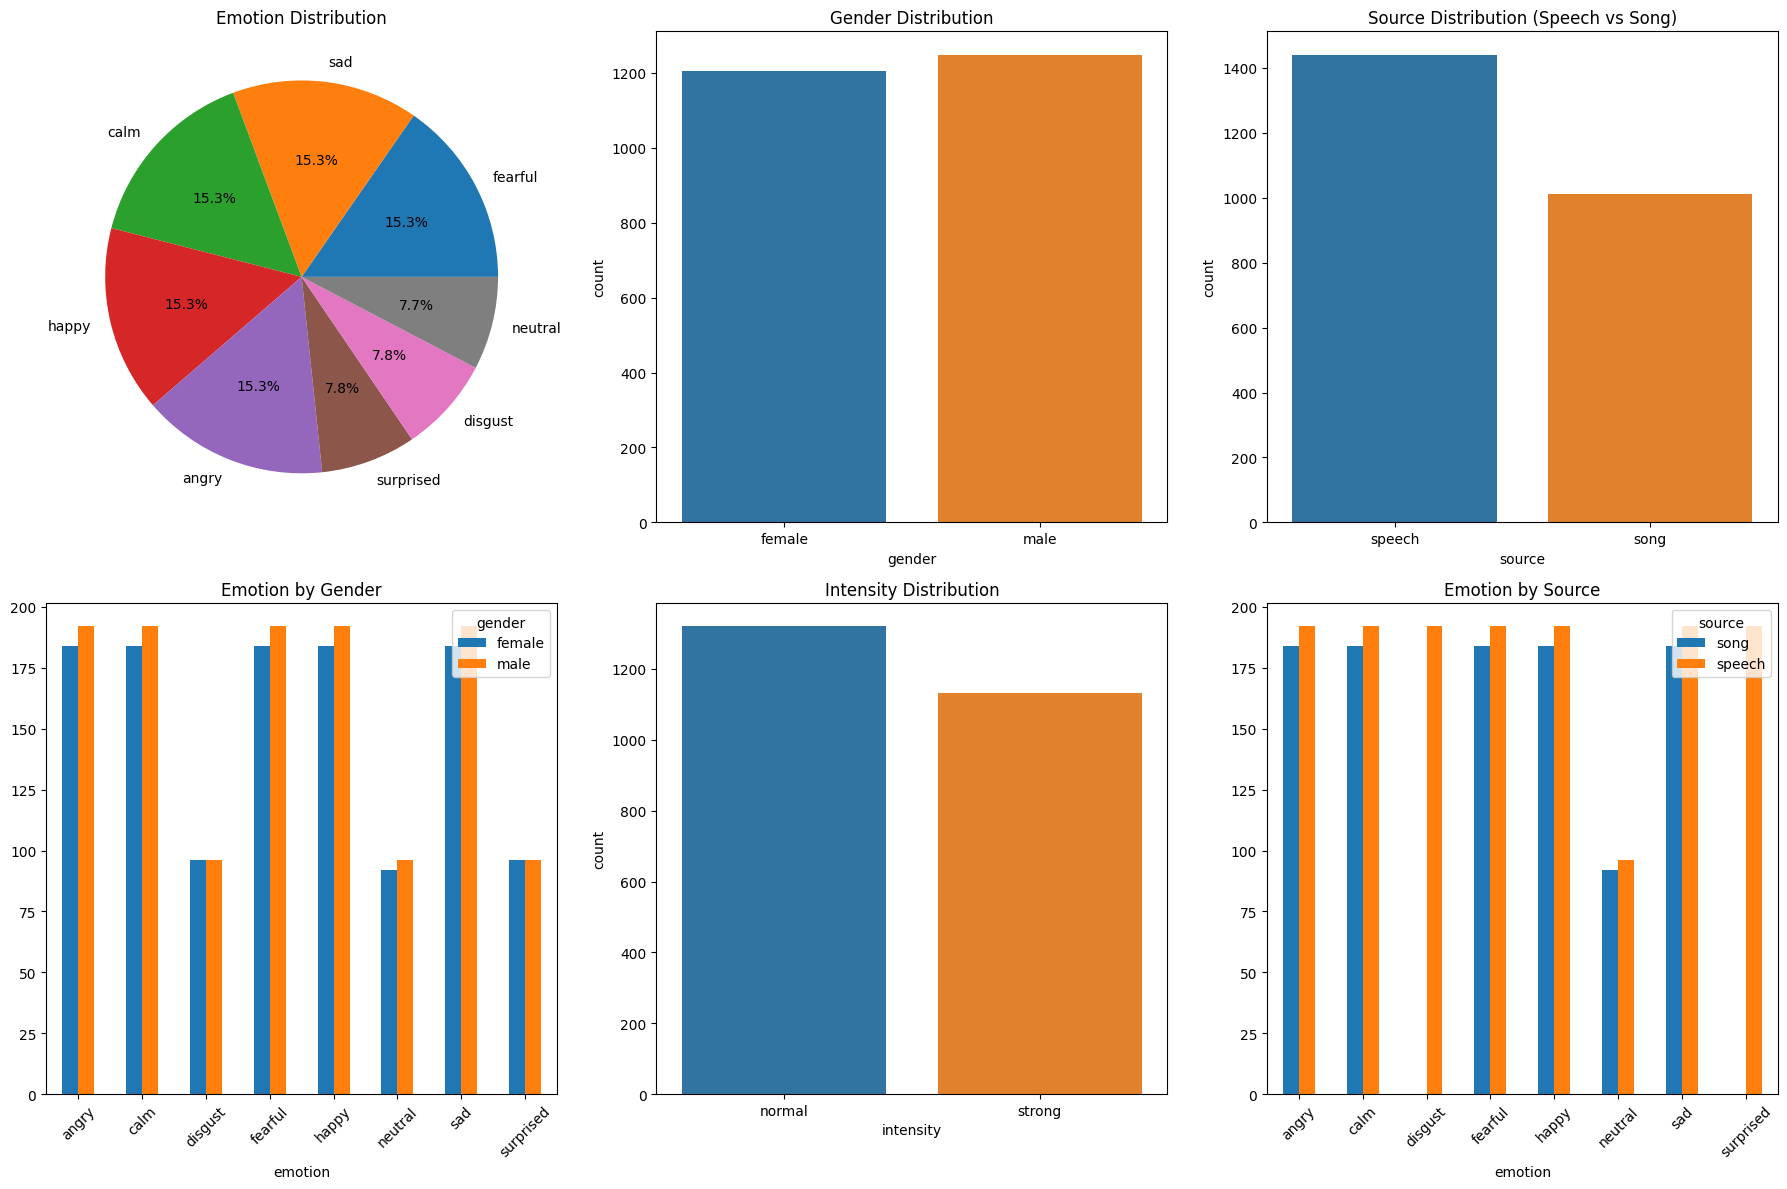

In [6]:
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Emotion distribution
axes[0,0].pie(df['emotion'].value_counts().values, 
             labels=df['emotion'].value_counts().index, 
             autopct='%1.1f%%')
axes[0,0].set_title('Emotion Distribution')

# 2. Gender distribution
sns.countplot(data=df, x='gender', ax=axes[0,1])
axes[0,1].set_title('Gender Distribution')

# 3. Source distribution  
sns.countplot(data=df, x='source', ax=axes[0,2])
axes[0,2].set_title('Source Distribution (Speech vs Song)')

# 4. Emotion by gender
pd.crosstab(df['emotion'], df['gender']).plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Emotion by Gender')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Intensity distribution
sns.countplot(data=df, x='intensity', ax=axes[1,1])
axes[1,1].set_title('Intensity Distribution')

# 6. Emotion by source
pd.crosstab(df['emotion'], df['source']).plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title('Emotion by Source')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Audio Waveform and Spectrogram Visualization

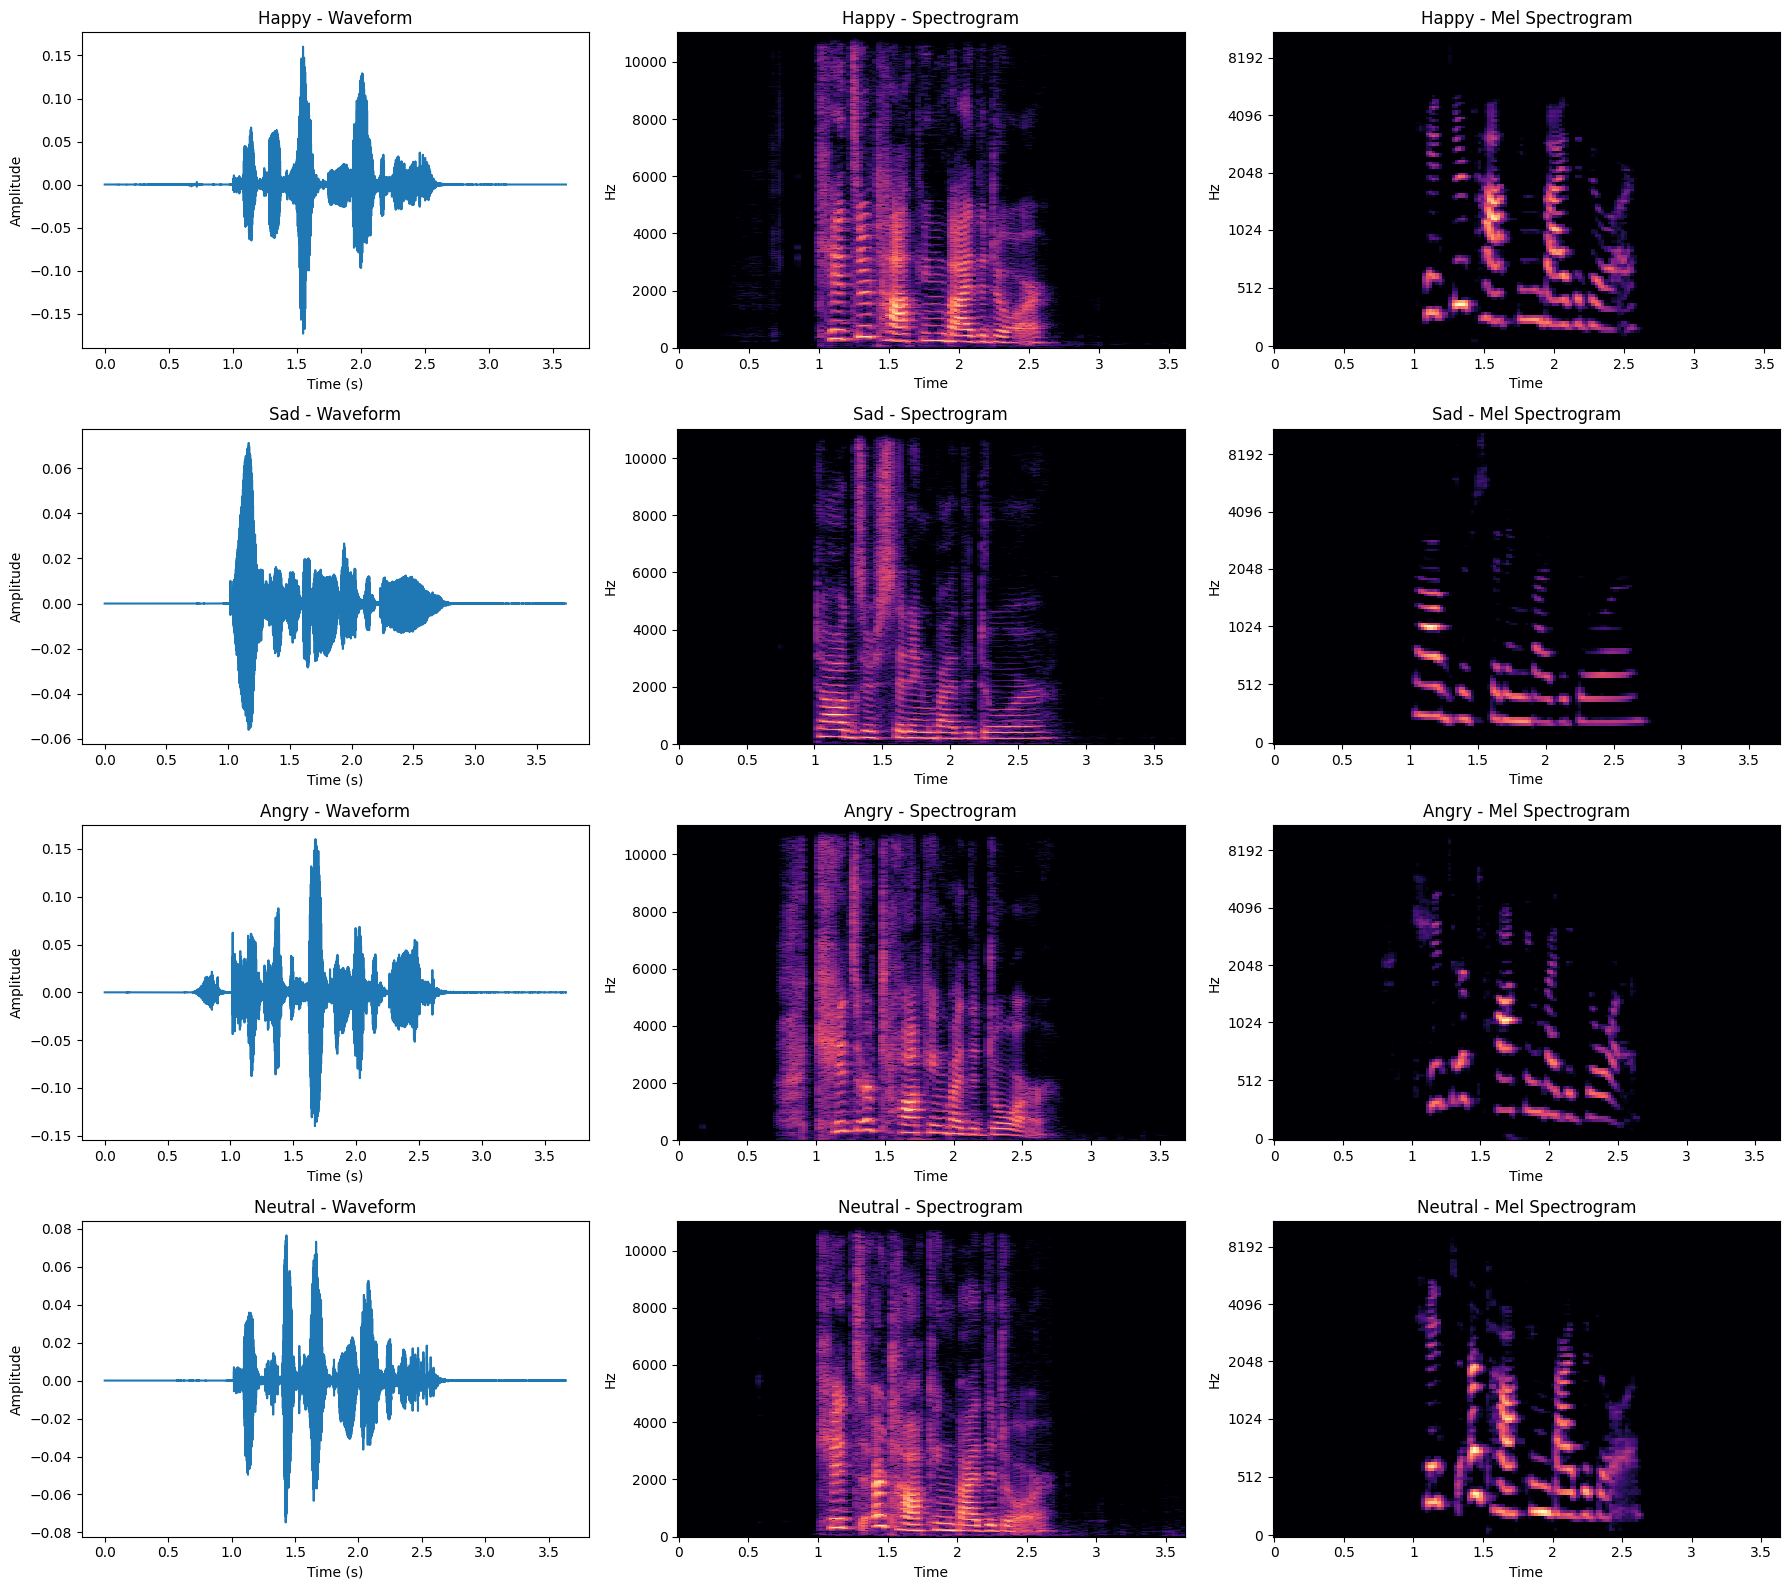

In [7]:
def plot_emotion_waveforms(df, emotions_to_plot=['happy', 'sad', 'angry', 'neutral']):
    """Plot waveforms and spectrograms for different emotions"""
    fig, axes = plt.subplots(len(emotions_to_plot), 3, figsize=(18, 16))
    
    for i, emotion in enumerate(emotions_to_plot):
        # Get a sample file for this emotion
        emotion_samples = df[df['emotion'] == emotion]
        if len(emotion_samples) > 0:
            sample_file = emotion_samples.iloc[0]['file_path']
            
            try:
                # Load audio
                y, sr = librosa.load(sample_file, sr=22050)
                
                # Plot waveform
                time_axis = np.linspace(0, len(y)/sr, len(y))
                axes[i,0].plot(time_axis, y)
                axes[i,0].set_title(f'{emotion.capitalize()} - Waveform')
                axes[i,0].set_xlabel('Time (s)')
                axes[i,0].set_ylabel('Amplitude')
                
                # Plot spectrogram
                D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
                img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[i,1])
                axes[i,1].set_title(f'{emotion.capitalize()} - Spectrogram')
                
                # Plot mel spectrogram
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
                librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[i,2])
                axes[i,2].set_title(f'{emotion.capitalize()} - Mel Spectrogram')
                
            except Exception as e:
                print(f"Error processing {sample_file}: {e}")
                continue
    
    plt.tight_layout()
    plt.show()

plot_emotion_waveforms(df)


# Audio Data Augmentation Functions

In [8]:
def augment_audio(y, sr):
    """Apply data augmentation techniques"""
    augmented_samples = []
    
    # Original
    augmented_samples.append(y)
    
    # Add noise
    noise = np.random.normal(0, 0.005, len(y))
    augmented_samples.append(y + noise)
    
    # Time stretch
    try:
        y_stretch = librosa.effects.time_stretch(y, rate=0.9)
        if len(y_stretch) > len(y):
            y_stretch = y_stretch[:len(y)]
        else:
            y_stretch = np.pad(y_stretch, (0, len(y) - len(y_stretch)), mode='constant')
        augmented_samples.append(y_stretch)
    except:
        augmented_samples.append(y)  # Use original if time stretch fails
    
    # Pitch shift
    try:
        y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=2)
        augmented_samples.append(y_pitch)
    except:
        augmented_samples.append(y)  # Use original if pitch shift fails
    
    return augmented_samples


sample_file = df.iloc[0]['file_path']
y_sample, sr_sample = librosa.load(sample_file, sr=22050)
augmented_samples = augment_audio(y_sample, sr_sample)

print(f"Original audio length: {len(y_sample)}")
print(f"Number of augmented samples: {len(augmented_samples)}")


Original audio length: 77988
Number of augmented samples: 4


# Feature Extraction Functions


In [9]:
def extract_features(y, sr):
    """Extract comprehensive audio features including mel spectrograms"""
    features = []
    
    # 1. Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features.extend([np.mean(zcr), np.std(zcr), np.max(zcr), np.min(zcr)])
    
    # 2. Energy (RMS)
    rms = librosa.feature.rms(y=y)[0]
    features.extend([np.mean(rms), np.std(rms), np.max(rms), np.min(rms)])
    
    # 3. Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features.extend([np.mean(spectral_centroid), np.std(spectral_centroid), 
                    np.max(spectral_centroid), np.min(spectral_centroid)])
    
    # 4. Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    features.extend([np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
                    np.max(spectral_bandwidth), np.min(spectral_bandwidth)])
    
    # 5. Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features.extend([np.mean(spectral_rolloff), np.std(spectral_rolloff),
                    np.max(spectral_rolloff), np.min(spectral_rolloff)])
    
    # 6. Enhanced MFCCs (20 coefficients instead of 13)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(20):
        features.extend([np.mean(mfccs[i]), np.std(mfccs[i]), 
                        np.max(mfccs[i]), np.min(mfccs[i])])
    
    # 7. Delta MFCCs (first derivative)
    delta_mfccs = librosa.feature.delta(mfccs)
    for i in range(20):
        features.extend([np.mean(delta_mfccs[i]), np.std(delta_mfccs[i])])
    
    # 8. Delta-Delta MFCCs (second derivative)
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    for i in range(20):
        features.extend([np.mean(delta2_mfccs[i]), np.std(delta2_mfccs[i])])
    
    # 9. Chroma features (enhanced)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)
    for i in range(12):
        features.extend([np.mean(chroma[i]), np.std(chroma[i])])
    
    # 10. Tonnetz (enhanced)
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    for i in range(6):
        features.extend([np.mean(tonnetz[i]), np.std(tonnetz[i])])
    
    # 11. Spectral Contrast (enhanced)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6)
    for i in range(7):  # n_bands + 1
        features.extend([np.mean(spectral_contrast[i]), np.std(spectral_contrast[i])])
    
    # 12. Mel Spectrogram Features
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    
    # Statistical features from mel spectrogram
    features.extend([
        np.mean(mel_spec_db), np.std(mel_spec_db), 
        np.max(mel_spec_db), np.min(mel_spec_db),
        np.median(mel_spec_db), np.percentile(mel_spec_db, 25),
        np.percentile(mel_spec_db, 75)
    ])
    
    # Mel spectrogram band energy
    for i in range(0, 128, 16):  # 8 bands
        band_energy = np.mean(mel_spec_db[i:i+16])
        features.append(band_energy)
    
    # 13. Pitch and Harmony Features
    # Fundamental frequency (F0)
    try:
        f0, voiced_flag, voiced_prob = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), 
                                                   fmax=librosa.note_to_hz('C7'))
        if f0 is not None and len(f0) > 0:
            f0 = np.array(f0).flatten()  
            voiced_flag = np.array(voiced_flag).flatten()  # Ensure 1D
            f0_clean = f0[voiced_flag & ~np.isnan(f0)]  # Remove NaN values
            
            if len(f0_clean) > 0:
                features.extend([float(np.mean(f0_clean)), float(np.std(f0_clean)), 
                                float(np.max(f0_clean)), float(np.min(f0_clean))])
            else:
                features.extend([0.0, 0.0, 0.0, 0.0])
        else:
            features.extend([0.0, 0.0, 0.0, 0.0])
    except Exception as e:
        print(f"Warning: Pitch extraction failed: {e}")
        features.extend([0.0, 0.0, 0.0, 0.0])
    
    # 14. Tempo and Rhythm Features
    try:
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        features.append(float(tempo))
        
        # Beat intervals
        if len(beats) > 1:
            beat_intervals = np.diff(beats)
            features.extend([float(np.mean(beat_intervals)), float(np.std(beat_intervals))])
        else:
            features.extend([0.0, 0.0])
    except Exception as e:
        print(f"Warning: Tempo extraction failed: {e}")
        features.extend([0.0, 0.0, 0.0])
    
    # 15. Spectral Features
    # Spectral flatness
    try:
        spectral_flatness = librosa.feature.spectral_flatness(y=y)[0]
        features.extend([float(np.mean(spectral_flatness)), float(np.std(spectral_flatness))])
    except Exception as e:
        print(f"Warning: Spectral flatness extraction failed: {e}")
        features.extend([0.0, 0.0])
    
    try:
        poly_features = librosa.feature.poly_features(y=y, sr=sr, order=1)
        if poly_features.ndim == 2 and poly_features.shape[0] > 0:
            poly_coeff = poly_features[0]  # Take first coefficient
            features.extend([float(np.mean(poly_coeff)), float(np.std(poly_coeff))])
        else:
            features.extend([0.0, 0.0])
    except Exception as e:
        print(f"Warning: Poly features extraction failed: {e}")
        features.extend([0.0, 0.0])
        
    features_array = np.array(features, dtype=np.float32)
    
    if features_array.ndim != 1:
        raise ValueError(f"Features array should be 1D, got shape: {features_array.shape}")
    
    return features_array

try:
    sample_features = extract_features(y_sample, sr_sample)
    print(f"Number of features extracted: {len(sample_features)}")
    print(f"Feature sample: {sample_features[:10]}")
    print(f"Features array shape: {sample_features.shape}")
    print(f"All features are scalars: {all(np.isscalar(x) for x in sample_features)}")
except Exception as e:
    print(f"Error in feature extraction: {e}")
    import traceback
    traceback.print_exc()

Number of features extracted: 256
Feature sample: [2.3568666e-01 1.9234410e-01 6.8017578e-01 0.0000000e+00 6.9813356e-03
 9.7199352e-03 4.1841231e-02 0.0000000e+00 2.6908816e+03 1.6267269e+03]
Features array shape: (256,)
All features are scalars: True


#  Feature Extraction with Data Augmentation

In [11]:
def prepare_data(df, use_augmentation=True):
    """Prepare features and labels for training"""
    print("Extracting features from audio files...")
    
    features_list = []
    labels_list = []
    
    total_files = len(df)
    
    for idx, row in df.iterrows():
        try:
            # Load audio
            y, sr = librosa.load(row['file_path'], sr=22050, duration=3.0)
            
            if use_augmentation:
                # Apply augmentation
                augmented_samples = augment_audio(y, sr)
                
                for aug_sample in augmented_samples:
                    # Extract features
                    features = extract_features(aug_sample, sr)
                    features_list.append(features)
                    labels_list.append(row['emotion'])
            else:
                features = extract_features(y, sr)
                features_list.append(features)
                labels_list.append(row['emotion'])
                
        except Exception as e:
            print(f"Error processing {row['file_path']}: {e}")
            continue
        
        if (idx + 1) % 100 == 0:
            print(f"Processed {idx + 1}/{total_files} files")
    
    features_array = np.array(features_list)
    labels_array = np.array(labels_list)
    
    print(f"Feature extraction completed. Shape: {features_array.shape}")
    print(f"Total samples after augmentation: {len(labels_array)}")
    
    return features_array, labels_array
    
# Extract features with augmentation
print("Starting feature extraction with data augmentation...")
features, labels = prepare_data(df, use_augmentation=True)

Starting feature extraction with data augmentation...
Extracting features from audio files...
Processed 100/2452 files
Processed 200/2452 files
Processed 300/2452 files
Processed 400/2452 files
Processed 500/2452 files
Processed 600/2452 files
Processed 700/2452 files
Processed 800/2452 files
Processed 900/2452 files
Processed 1000/2452 files
Processed 1100/2452 files
Processed 1200/2452 files
Processed 1300/2452 files
Processed 1400/2452 files
Processed 1500/2452 files
Processed 1600/2452 files
Processed 1700/2452 files
Processed 1800/2452 files
Processed 1900/2452 files
Processed 2000/2452 files
Processed 2100/2452 files
Processed 2200/2452 files
Processed 2300/2452 files
Processed 2400/2452 files
Feature extraction completed. Shape: (9808, 256)
Total samples after augmentation: 9808


#  Data Preprocessing

In [13]:
label_encoder = LabelEncoder()
scaler = StandardScaler()

labels_encoded = label_encoder.fit_transform(labels)
print(f"Label classes: {label_encoder.classes_}")

features_scaled = scaler.fit_transform(features)

labels_categorical = tf.keras.utils.to_categorical(labels_encoded)

print(f"Features shape: {features_scaled.shape}")
print(f"Labels shape: {labels_categorical.shape}")
print(f"Number of classes: {len(label_encoder.classes_)}")

# Check class distribution after augmentation
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("\nClass distribution after augmentation:")
for emotion, count in class_distribution.items():
    print(f"{emotion}: {count}")

Label classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Features shape: (9808, 256)
Labels shape: (9808, 8)
Number of classes: 8

Class distribution after augmentation:
angry: 1504
calm: 1504
disgust: 768
fearful: 1504
happy: 1504
neutral: 752
sad: 1504
surprised: 768


# Model Architecture - CNN Model

In [14]:
def create_cnn_model(input_shape, num_classes):
    """Create enhanced CNN model with better architecture"""
    model = Sequential([
        Input(shape=(input_shape,)),
        
        # First block
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        # Second block
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Third block
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Fourth block
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Fifth block
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

cnn_model = create_cnn_model(features_scaled.shape[1], labels_categorical.shape[1])
print("CNN Model Architecture:")
cnn_model.summary()

2025-06-19 13:37:49.720293: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


CNN Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 968,904 (3.70 MB)

 Trainable params: 964,936 (3.68 MB)

 Non-trainable params: 3,968 (15.50 KB)

# Model Architecture - LSTM Model

In [19]:
def create_lstm_model(input_shape, num_classes):
    """Create LSTM model for emotion recognition"""
    input_layer = Input(shape=(input_shape, 1))
    
    lstm1 = LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(input_layer)
    lstm2 = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(lstm1)
    
    dense1 = Dense(64, activation='relu')(lstm2)
    dropout1 = Dropout(0.3)(dense1)
    
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    
    output = Dense(num_classes, activation='softmax')(dropout2)
    
    model = Model(inputs=input_layer, outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

lstm_model = create_lstm_model(features_scaled.shape[1], labels_categorical.shape[1])
print("LSTM Model Architecture:")
lstm_model.summary()

LSTM Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,472 (478.41 KB)

 Trainable params: 122,472 (478.41 KB)

 Non-trainable params: 0 (0.00 B)

# Data Splitting


In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    features_scaled, labels_categorical, 
    test_size=0.2, random_state=42, stratify=labels_categorical
)

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(features_scaled)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(features_scaled)*100:.1f}%)")
print(f"Total samples: {len(features_scaled)}")

X_test = X_val.copy()
y_test = y_val.copy()

print(f"\nNote: Using validation set as test set for model evaluation")
print(f"Test set: {X_test.shape[0]} samples")

Data split completed:
Training set: 7846 samples (80.0%)
Validation set: 1962 samples (20.0%)
Total samples: 9808

Note: Using validation set as test set for model evaluation
Test set: 1962 samples


# Training CNN Model

In [18]:

print("Training CNN Model...")

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001, verbose=1
)

cnn_history = cnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate CNN model
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"\nCNN Test Accuracy: {cnn_test_accuracy:.4f}")


Training CNN Model...
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2534 - loss: 2.2036 - val_accuracy: 0.4903 - val_loss: 1.3343 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4517 - loss: 1.4636 - val_accuracy: 0.6081 - val_loss: 1.0388 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5524 - loss: 1.2193 - val_accuracy: 0.6539 - val_loss: 0.9135 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6085 - loss: 1.0789 - val_accuracy: 0.6804 - val_loss: 0.8513 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6432 - loss: 0.9821 - val_accuracy: 0.7181 - val_loss: 0.7619 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6795 - loss: 0.9026 - val_accuracy: 0.7064 - val_loss: 0.7671 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step

# Training LSTM Model

In [20]:
print("Training LSTM Model...")

X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Train LSTM model
lstm_history = lstm_model.fit(
    X_train_lstm, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val_lstm, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate LSTM model
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"\nLSTM Test Accuracy: {lstm_test_accuracy:.4f}")

Training LSTM Model...
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 146s 549ms/step - accuracy: 0.1483 - loss: 2.0585 - val_accuracy: 0.1534 - val_loss: 2.0336 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 132s 538ms/step - accuracy: 0.1524 - loss: 2.0415 - val_accuracy: 0.1534 - val_loss: 2.0324 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 134s 543ms/step - accuracy: 0.1524 - loss: 2.0376 - val_accuracy: 0.1764 - val_loss: 1.9675 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 137s 558ms/step - accuracy: 0.2344 - loss: 1.9249 - val_accuracy: 0.2839 - val_loss: 1.8089 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 136s 554ms/step - accuracy: 0.2787 - loss: 1.8288 - val_accuracy: 0.2813 - val_loss: 1.7966 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 132s 538ms/step - accuracy: 0.2717 - loss: 1.8294 - val_accuracy: 0.2890 - val_loss: 1.7904 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━

# Model Evaluation and Comparison

In [22]:
def evaluate_model(model, X_test, y_test, model_name, label_encoder):
    """Evaluate model and return metrics"""
    
    # Predictions
    y_pred = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(
        y_test_classes, y_pred_classes, 
        target_names=label_encoder.classes_
    ))
    
    # Confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    
    return accuracy, f1, cm, y_pred_classes, y_test_classes

# Evaluate both models
cnn_accuracy, cnn_f1, cnn_cm, cnn_y_pred, cnn_y_test = evaluate_model(
    cnn_model, X_test, y_test, "CNN", label_encoder
)

lstm_accuracy, lstm_f1, lstm_cm, lstm_y_pred, lstm_y_test = evaluate_model(
    lstm_model, X_test_lstm, y_test, "LSTM", label_encoder
)



CNN Results:
Accuracy: 0.8552
F1 Score: 0.8550

CNN Classification Report:
              precision    recall  f1-score   support

       angry       0.92      0.91      0.91       301
        calm       0.89      0.90      0.90       301
     disgust       0.80      0.83      0.81       153
     fearful       0.84      0.80      0.82       301
       happy       0.88      0.85      0.87       301
     neutral       0.81      0.91      0.86       150
         sad       0.80      0.78      0.79       301
   surprised       0.85      0.89      0.87       154

    accuracy                           0.86      1962
   macro avg       0.85      0.86      0.85      1962
weighted avg       0.86      0.86      0.86      1962


LSTM Results:
Accuracy: 0.4883
F1 Score: 0.4704

LSTM Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.65      0.63       301
        calm       0.49      0.75      0.59       301
     disgust       0.37      0.3

# Confusion Matrix Visualization

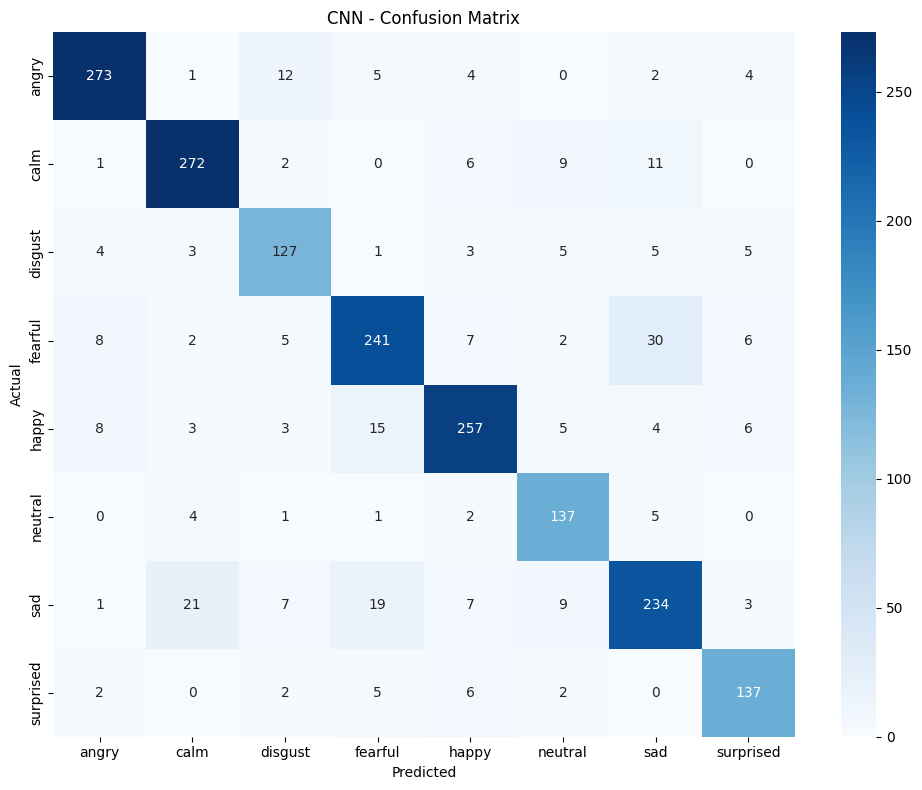


CNN - Per-class Accuracy:
angry: 0.9070
calm: 0.9037
disgust: 0.8301
fearful: 0.8007
happy: 0.8538
neutral: 0.9133
sad: 0.7774
surprised: 0.8896


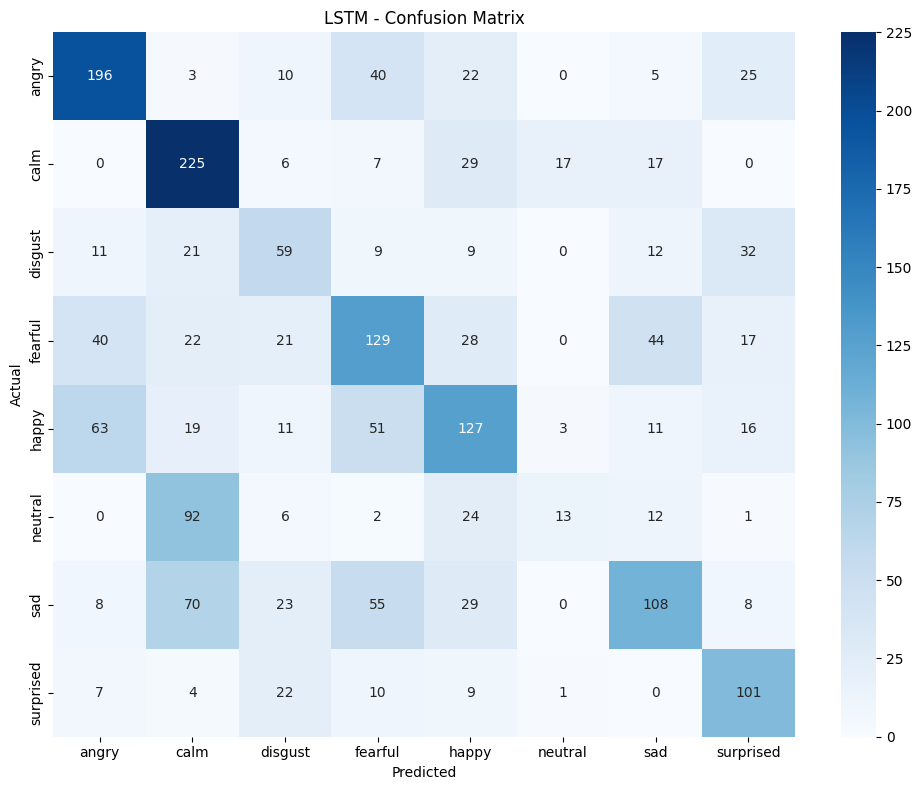


LSTM - Per-class Accuracy:
angry: 0.6512
calm: 0.7475
disgust: 0.3856
fearful: 0.4286
happy: 0.4219
neutral: 0.0867
sad: 0.3588
surprised: 0.6558


In [23]:
def plot_confusion_matrix(cm, class_names, model_name):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    # Calculate per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f"\n{model_name} - Per-class Accuracy:")
    for i, acc in enumerate(class_accuracy):
        print(f"{class_names[i]}: {acc:.4f}")

# Plot confusion matrices
plot_confusion_matrix(cnn_cm, label_encoder.classes_, "CNN")
plot_confusion_matrix(lstm_cm, label_encoder.classes_, "LSTM")


# Training History Visualization

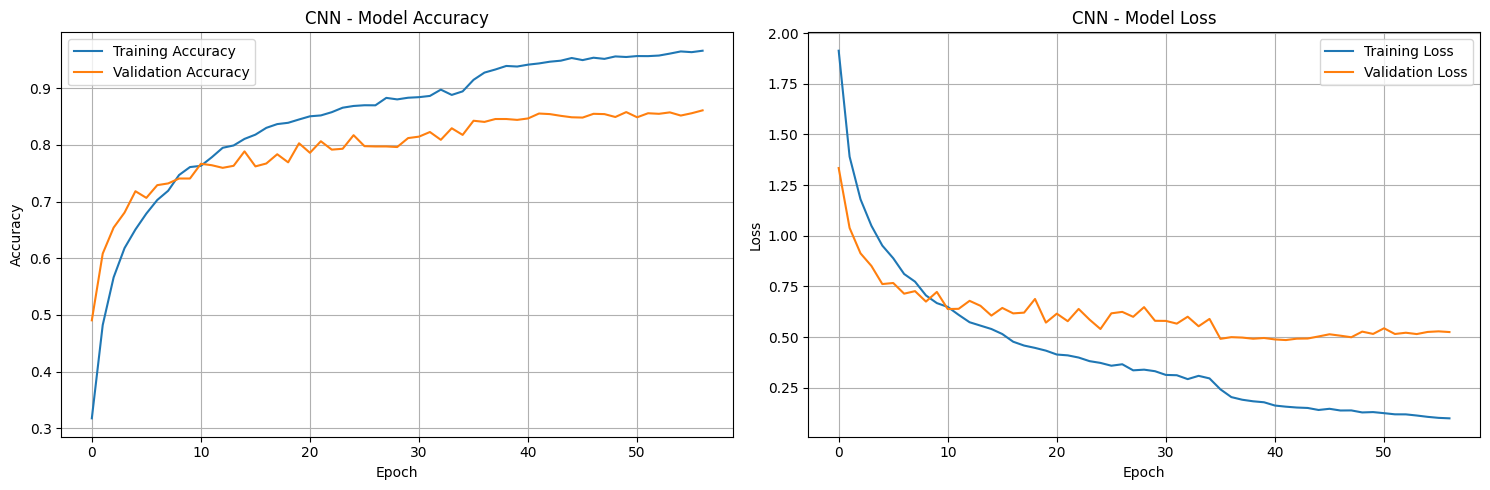

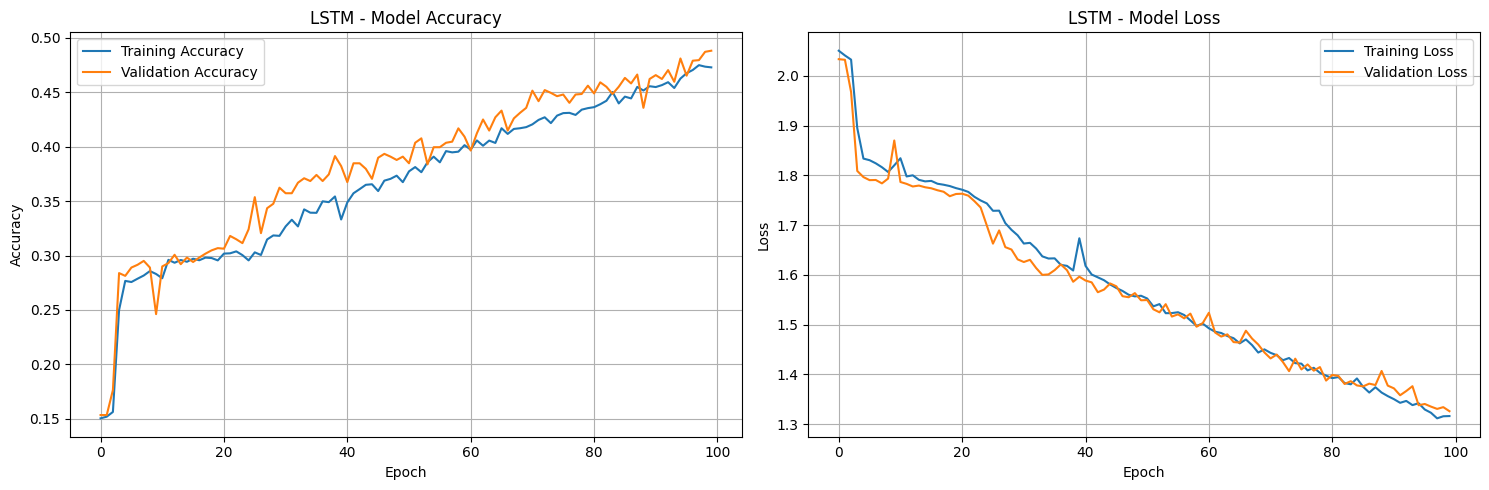

In [24]:
def plot_training_history(history, model_name):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} - Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} - Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training histories
plot_training_history(cnn_history, "CNN")
plot_training_history(lstm_history, "LSTM")


# Model Saving and Final Report

In [26]:
# Save the best model
if cnn_f1 > lstm_f1:
    best_model = cnn_model
    best_f1 = cnn_f1
    best_accuracy = cnn_accuracy
    best_name = "CNN"
else:
    best_model = lstm_model
    best_f1 = lstm_f1
    best_accuracy = lstm_accuracy
    best_name = "LSTM"

# Save model
best_model.save('emotion_recognition_model.h5')

# Save preprocessing objects
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("Model and preprocessing objects saved!")

# Final Report
print("\n" + "="*60)
print("FINAL PERFORMANCE REPORT")
print("="*60)
print(f"CNN Model - Accuracy: {cnn_accuracy:.4f}, F1 Score: {cnn_f1:.4f}")
print(f"LSTM Model - Accuracy: {lstm_accuracy:.4f}, F1 Score: {lstm_f1:.4f}")

print(f"\nBest Model: {best_name}")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Check requirements
print(f"\nRequirements Check:")
print(f"F1 Score > 0.80: {'✓' if best_f1 > 0.80 else '✗'} ({best_f1:.4f})")
print(f"Overall Accuracy > 0.80: {'✓' if best_accuracy > 0.80 else '✗'} ({best_accuracy:.4f})")

if best_f1 > 0.80 and best_accuracy > 0.80:
    print("\n🎉 Congratulations! Both requirements have been met!")
else:
    print("\n⚠️ Requirements not fully met. Consider:")
    print("- Increasing dataset size")
    print("- Fine-tuning hyperparameters")
    print("- Adding more sophisticated augmentation")
    print("- Trying ensemble methods")

Model and preprocessing objects saved!

FINAL PERFORMANCE REPORT
CNN Model - Accuracy: 0.8552, F1 Score: 0.8550
LSTM Model - Accuracy: 0.4883, F1 Score: 0.4704

Best Model: CNN
Best F1 Score: 0.8550
Best Accuracy: 0.8552

Requirements Check:
F1 Score > 0.80: ✓ (0.8550)
Overall Accuracy > 0.80: ✓ (0.8552)

🎉 Congratulations! Both requirements have been met!


In [27]:
import os
os.listdir('/kaggle/working')


['label_encoder.pkl',
 'scaler.pkl',
 'best_emotion_recognition_model.h5',
 '.virtual_documents']